## Test CLIP

In [2]:
import pickle as pkl
import argparse
import os
import pickle
import random
import numpy as np
import torch
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

from pcbm.data import get_dataset
from pcbm.concepts import ConceptBank
from pcbm.models import PosthocLinearCBM, get_model
from pcbm.training_tools import load_or_compute_projections

UNIVERSAL_SEED = 2024
BATCH_SIZE = 64
NUM_WORKERS = 4
CONCEPT_BANK_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank/multimodal_concept_clip:RN50_cifar10_recurse:1.pkl"
OUT_PUT_DIR_PATH = "exps/test"
CKPT_PATH = "data/ckpt/CIFAR_10/pcbm_cifar10__clip:RN50__multimodal_concept_clip:RN50_cifar10_recurse:1__lam:0.0002__alpha:0.99__seed:42.ckpt"
DATASET_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank"
BACKBONE_NAME = "clip:ViT-B/32"
DEVICE = "cuda"

In [3]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_random_seed(UNIVERSAL_SEED)

In [ ]:
all_concepts = pkl.load(open(CONCEPT_BANK_PATH, 'rb'))
all_concept_names = list(all_concepts.keys())
print(f"Bank path: {CONCEPT_BANK_PATH}. {len(all_concept_names)} concepts will be used.")
concept_bank = ConceptBank(all_concepts, DEVICE)

import clip
clip_backbone_name = BACKBONE_NAME.split(":")[1]
backbone, preprocess = clip.load(clip_backbone_name, device=DEVICE, download_root="/home/ksas/Public/model_zoo/clip")
backbone = backbone.eval()
backbone = backbone.float()
model = None

backbone = backbone.to(DEVICE)
backbone.eval()

In [ ]:
backbone.visual

In [4]:
with open("cifar10_concept.txt", "w+") as input_stream:
    for idx, concept_name in enumerate(concept_bank.concept_info.concept_names):
        input_stream.write(f"{idx}\t-{concept_name}\n")

In [ ]:
posthoc_layer:PosthocLinearCBM = torch.load(CKPT_PATH, map_location=DEVICE)
print(posthoc_layer.analyze_classifier(k=5))
print(posthoc_layer.names)
print(posthoc_layer.names.__len__())

In [ ]:
from torchvision import datasets
from pcbm.learn_concepts_multimodal import *
trainset = datasets.CIFAR10(root=DATASET_PATH, train=True,
                            download=True, transform=preprocess)
testset = datasets.CIFAR10(root=DATASET_PATH, train=False,
                            download=True, transform=preprocess)
classes = trainset.classes
class_to_idx = {c: i for (i,c) in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                    shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
def show_image(images:torch.Tensor):
    import torch
    import torchvision
    import matplotlib.pyplot as plt

    # 使用 torchvision.utils.make_grid 将 64 张图片排列成 8x8 的网格
    grid_img = torchvision.utils.make_grid(images, nrow=8, normalize=True)

    # 转换为 NumPy 格式以便用 matplotlib 显示
    plt.imshow(grid_img.permute(1, 2, 0))  # 转换为 [H, W, C]
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

for idx, data in enumerate(train_loader):
    print(data.__len__())
    print(f"x: {data[0].size()}")
    print(f"y: {data[1].size()}")
    batch_X, batch_Y = data
    batch_X = batch_X.to(DEVICE)
    batch_Y = batch_Y.to(DEVICE)
    
    batch_X.requires_grad_(True)
    embeddings = backbone.encode_image(batch_X)
    projs = posthoc_layer.compute_dist(embeddings)
    predicted_Y = posthoc_layer.forward_projs(projs)
    accuracy = (predicted_Y.argmax(1) == batch_Y).float().mean().item()
    
    _, topk_indices = torch.topk(projs, 5, dim=1)
    topk_concept = [[posthoc_layer.names[idx] for idx in row] for row in topk_indices]

    
    show_image(batch_X.detach().cpu())
    print(f"embeddings: {embeddings.size()}")
    print(f"projections: {projs.size()}")
    print(f"predicted_Y: {predicted_Y.size()}")
    print(f"accuracy: {accuracy}")
    # accuracy_idx.append(accuracy)
    import pdb; pdb.set_trace()
    
# print(accuracy_idx)
    

In [ ]:
import pickle as pkl
import os
from constants import dataset_cosntants
from pcbm.data.cub import CUBConceptDataset, get_concept_dicts
from pcbm.concepts import ConceptBank

CUB_CONCEPT_BANK_PATH =  "/home/ksas/Public/datasets/cub_concept_bank/cub_resnet18_cub_0.1_100.pkl"
DEVICE = "cuda"

TRAIN_PKL = os.path.join(dataset_cosntants.CUB_PROCESSED_DIR, "train.pkl")
metadata = pkl.load(open(TRAIN_PKL, "rb"))

concept_info = get_concept_dicts(metadata=metadata)
concept_info[0].keys()

In [ ]:
print(concept_info.__len__())
print(concept_info[0][0].__len__())
print(concept_info[0][1].__len__())

## Test Layer Grad CAM

In [1]:
import clip
from clip.model import CLIP, ModifiedResNet, VisionTransformer
import torch
from PIL import Image
import torchvision.transforms as transforms

BACKBONE_NAME = "clip:ViT-B/32"
DEVICE = "cuda"
clip_backbone_name = BACKBONE_NAME.split(":")[1]
backbone, preprocess = clip.load(clip_backbone_name, device=DEVICE, download_root="/home/ksas/Public/model_zoo/clip")
backbone = backbone.eval()
backbone = backbone.float()
normalizer = transforms.Compose(preprocess.transforms[-1:])
preprocess = transforms.Compose(preprocess.transforms[:-1])
print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x77d78e88e160>
    ToTensor()
)


In [2]:
from utils.explain_utils import *
from captum.attr import visualization, GradientAttribution, LayerAttribution

image_attn_blocks = list(dict(backbone.visual.transformer.resblocks.named_children()).values())
last_blocks = image_attn_blocks[-1].ln_1
layer_grad_cam = layer_grad_cam_vit(backbone,
                                last_blocks)

(tensor([[16.4628, 22.7153, 22.2767]], device='cuda:0', grad_fn=<MmBackward0>), tensor([[16.4628],
        [22.7153],
        [22.2767]], device='cuda:0', grad_fn=<TBackward0>))
tensor([[[[ 8.1194e-04,  1.9753e-04,  8.5030e-04,  ..., -2.5991e-04,
           -3.4828e-04,  3.4645e-04],
          [ 5.7919e-04,  1.0336e-03,  5.0641e-04,  ...,  2.1189e-04,
            6.0660e-04,  1.9552e-04],
          [ 8.1485e-04,  9.8082e-04,  3.4817e-04,  ..., -4.7558e-04,
            5.3679e-05,  2.7448e-04],
          ...,
          [ 1.6567e-04, -3.2354e-04,  2.8459e-05,  ...,  6.2265e-05,
           -9.7314e-05, -2.9161e-04],
          [ 4.8046e-04,  2.8764e-04,  2.8989e-04,  ...,  9.1561e-04,
           -8.3319e-04, -2.2932e-04],
          [-2.4227e-04, -3.4107e-04, -3.4439e-04,  ...,  3.6814e-04,
            1.3711e-04, -1.7808e-04]],

         [[-6.9164e-06,  9.9889e-05, -2.3714e-04,  ..., -7.7161e-05,
           -6.9993e-05,  1.7407e-04],
          [ 2.9883e-04,  3.7963e-04,  4.7030e-04,  ..., 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].


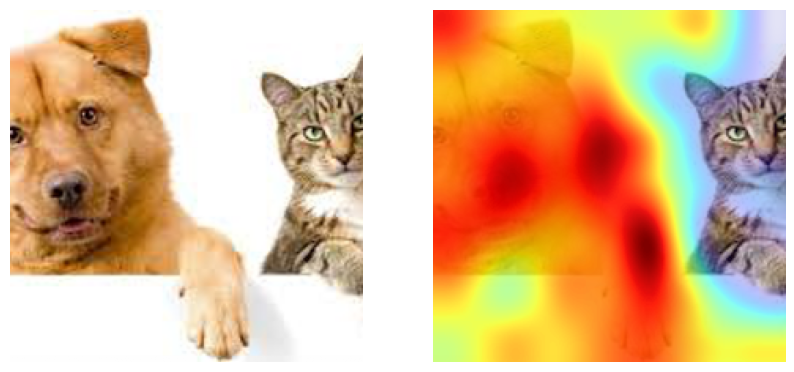

In [4]:
from visual_utils import *

image:torch.Tensor = preprocess(Image.open("data/images/cat_and_dog.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["car", "a dog", "a cat"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 1, additional_args = {"text": text})
print(attributions)
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=False,
        save_to=None)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].


(tensor([[27.3187, 24.6391, 23.8685, 23.8514, 23.5813, 18.1111]],
       device='cuda:0', grad_fn=<MmBackward0>), tensor([[27.3187],
        [24.6391],
        [23.8685],
        [23.8514],
        [23.5813],
        [18.1111]], device='cuda:0', grad_fn=<TBackward0>))


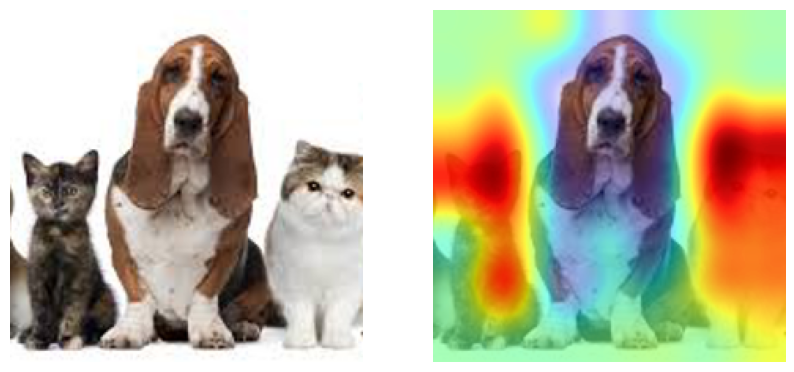

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].


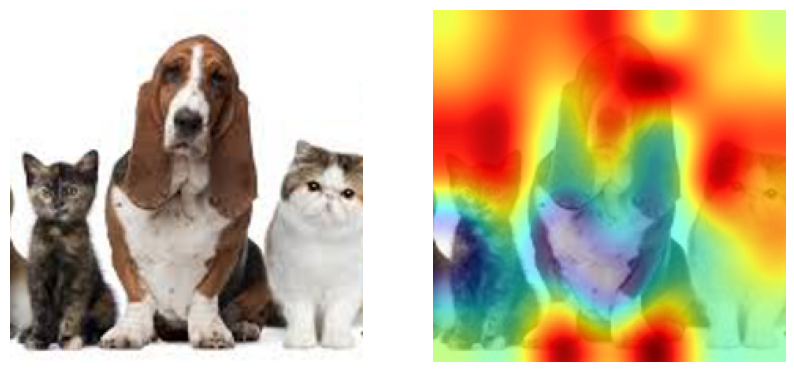

In [7]:
image:torch.Tensor = preprocess(Image.open("data/images/multi_dog_and_cat.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["cat and dog", "dog", "cat", "many dogs", "many cats", "eyees"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 2, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=False,
        save_to=None)

attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 5, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=False,
        save_to=None)


In [ ]:
image:torch.Tensor = preprocess(Image.open("data/layer_grad_cam/propellers_images/946-original_image.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["airplane", "propellers", "landing gear"]).to(DEVICE)
print(backbone(normalizer(image), text))

attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 0, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)

attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 1, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)

attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 2, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)


In [ ]:
image:torch.Tensor = preprocess(Image.open("data/images/dog_cat.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["car", "dog", "cat"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 2, additional_args = {"text": text})
print(attributions)
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=False,
        save_to=None)

In [ ]:
image:torch.Tensor = preprocess(Image.open("data/images/glasses.png")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["man with eyeglasses"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 0, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].


(tensor([[17.4667, 24.1139, 23.9167, 16.3902, 24.0672]], device='cuda:0',
       grad_fn=<MmBackward0>), tensor([[17.4667],
        [24.1139],
        [23.9167],
        [16.3902],
        [24.0672]], device='cuda:0', grad_fn=<TBackward0>))


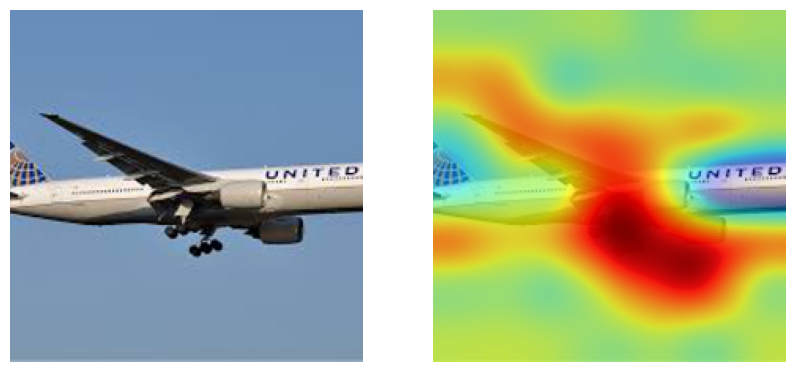

In [16]:
image:torch.Tensor = preprocess(Image.open("data/images/airplane.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["propellers",
                      "heavier-than-air craft",
                      "fuselage",
                      "accelerator",
                      "landing gear"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 4, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)

## Test OPEN_CLIP

In [ ]:
import open_clip
open_clip.list_pretrained()

In [ ]:
import torch
from PIL import Image
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai', cache_dir="/home/ksas/Public/model_zoo/clip")
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

image = preprocess(Image.open("data/images/cat_and_dog.jpg")).unsqueeze(0)
text = tokenizer(["a diagram", "a dog", "a cat"])
print(preprocess)
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs) 

## Output CIFAR10

In [2]:
import clip
import torch
import torch.nn as nn
from torchvision import datasets
from constants import dataset_constants
import torchvision.transforms as transforms

trainset = datasets.CIFAR10(root=dataset_constants.CIFAR10_DIR, train=True,
                            download=False, transform=None)
testset = datasets.CIFAR10(root=dataset_constants.CIFAR10_DIR, train=False,
                            download=False, transform=None)
classes = trainset.classes
class_to_idx = {c: i for (i,c) in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

print(idx_to_class)
plt.imshow(trainset[100][0])
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [ ]:
import os
from tqdm import tqdm

CIFAR10_TRAINING_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank/training_imgs"
os.makedirs(CIFAR10_TRAINING_PATH, exist_ok=True)
for idx, (image, cls) in tqdm(enumerate(trainset), total=trainset.__len__()):
    image.save(os.path.join(CIFAR10_TRAINING_PATH, f"{idx:05d}_{idx_to_class[cls]}.png"), format='png')

In [ ]:
CIFAR10_TESTING_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank/testing_imgs"
os.makedirs(CIFAR10_TESTING_PATH, exist_ok=True)
for idx, (image, cls) in tqdm(enumerate(testset), total=testset.__len__()):
    image.save(os.path.join(CIFAR10_TESTING_PATH, f"{idx:05d}_{idx_to_class[cls]}.png"), format='png')

In [ ]:
import pandas as pd
# 读取 CSV 文件
df = pd.read_csv('/home/ksas/Public/datasets/cifar10_concept_bank/training_imgs.csv')

# 打印前几行，验证读取是否成功
print(df.head())
print(df["filepath"])

## CLIP full-shot evaluation

In [1]:
from open_clip import get_input_dtype, get_tokenizer, build_zero_shot_classifier, \
    IMAGENET_CLASSNAMES, OPENAI_IMAGENET_TEMPLATES
from open_clip_train.precision import get_autocast

CIFAR10_CLASSNAME = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


def run(model, classifier, dataloader):
    device = torch.device("cuda")
    autocast = get_autocast("amp", device_type=device.type)
    input_dtype = get_input_dtype("amp")

    with torch.inference_mode():
        top1, top5, n = 0., 0., 0.
        for images, target in tqdm(dataloader, unit_scale=64):
            images = images.to(device=device, dtype=input_dtype)
            target = target.to(device)

            with autocast():
                # predict
                output = model(image=images)
                image_features = output['image_features'] if isinstance(output, dict) else output[0]
                logits = 100. * image_features @ classifier

            # measure accuracy
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1 += acc1
            top5 += acc5
            n += images.size(0)

    top1 = (top1 / n)
    top5 = (top5 / n)
    return top1, top5
 
def zero_shot_eval(model, dataloader, tokenizer):
    print('Starting zero-shot imagenet.')
    print('Building zero-shot classifier')
    device = torch.device("cuda")
    autocast = get_autocast("amp", device_type=device.type)
    with autocast():
        classifier = build_zero_shot_classifier(
            model,
            tokenizer=tokenizer,
            classnames=CIFAR10_CLASSNAME,
            templates= (
                lambda c: f'a picture of a {c}.',
            ),
            num_classes_per_batch=10,
            device=device,
            use_tqdm=True,
        )

    print('Using classifier')
    results = {}
    top1, top5 = run(model, classifier, dataloader)
    print(f"top1: {top1}, top5: {top5}")
    print('Finished zero-shot imagenet.')

    return results

In [ ]:
import torch
from PIL import Image
import open_clip
MODEL_NAME = 'ViT-B-32'
ORIGINAL_CKPT_PATH = "/home/ksas/Public/model_zoo/clip/ViT-B-32.pt"
REFINED_CKPT_PATH = "/home/ksas/uzuki_space/open_clip/src/logs/2024_10_24-10_48_09-model_ViT-B-32-lr_1e-05-b_128-j_3-p_amp/checkpoints/epoch_2.pt"
model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=ORIGINAL_CKPT_PATH, cache_dir="/home/ksas/Public/model_zoo/clip")
model.cuda().eval()
tokenizer = open_clip.get_tokenizer(MODEL_NAME)

from common_utils import *

trainset, testset, class_to_idx, idx_to_class, train_loader, test_loader = load_dataset(dataset_configure(
            dataset = 'cifar10',
            batch_size = 64,
            num_workers = 4,
        ), preprocess)

zero_shot_eval(model, train_loader, tokenizer)
zero_shot_eval(model, test_loader, tokenizer)


model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=REFINED_CKPT_PATH, cache_dir="/home/ksas/Public/model_zoo/clip")
model.cuda().eval()

zero_shot_eval(model, train_loader, tokenizer)
zero_shot_eval(model, test_loader, tokenizer)


In [ ]:
from cnn import net